# Volume 3: ARMA Models
    Bryant McArthur
    Math 405
    Pi Day

In [24]:
!pip install pydataset
!pip install statsmodels


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [57]:
from scipy.stats.distributions import norm
from scipy.optimize import fmin, minimize
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VARMAX
import statsmodels.api as sm
from pydataset import data as pydata
from statsmodels.tsa.stattools import arma_order_select_ic as order_select
import pandas as pd

## Helper Functions

In [51]:
def kalman(F, Q, H, time_series):
    # Get dimensions
    dim_states = F.shape[0]

    # Initialize variables
    # covs[i] = P_{i | i-1}
    covs = np.zeros((len(time_series), dim_states, dim_states))
    mus = np.zeros((len(time_series), dim_states))

    # Solve of for first mu and cov
    covs[0] = np.linalg.solve(np.eye(dim_states**2) - np.kron(F,F), 
                              np.eye(dim_states**2).dot(Q.flatten())).reshape(
                            (dim_states,dim_states))
    mus[0] = np.zeros((dim_states,))

    # Update Kalman Filter
    for i in range(1, len(time_series)):
        #FIXME
        t1 = np.linalg.solve(H.dot(covs[i-1]).dot(H.T),np.eye(H.shape[0]))
        t2 = covs[i-1].dot(H.T.dot(t1.dot(H.dot(covs[i-1]))))
        covs[i] = F.dot((covs[i-1] - t2).dot(F.T)) + Q
        mus[i] = F.dot(mus[i-1]) + F.dot(covs[i-1].dot(H.T.dot(t1))).dot(
                time_series[i-1] - H.dot(mus[i-1]))
    return mus, covs

def state_space_rep(phis, thetas, mu, sigma):
    # Initialize variables
    dim_states = max(len(phis), len(thetas)+1)
    dim_time_series = 1 #hardcoded for 1d time_series

    F = np.zeros((dim_states,dim_states))
    Q = np.zeros((dim_states, dim_states))
    H = np.zeros((dim_time_series, dim_states))

    # Create F
    F[0][:len(phis)] = phis
    F[1:,:-1] = np.eye(dim_states - 1)
    # Create Q
    Q[0][0] = sigma**2
    # Create H
    H[0][0] = 1.
    H[0][1:len(thetas)+1] = thetas

    return F, Q, H, dim_states, dim_time_series

## Problem 1

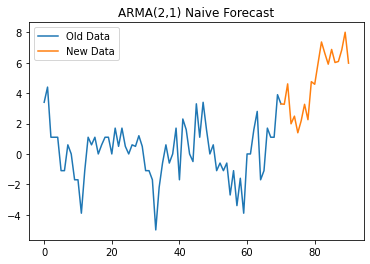

In [5]:
def arma_forecast_naive(file='weather.npy',p=2,q=1,n=20):
    """
    Perform ARMA(2,1) on data. Let error terms be drawn from
    a standard normal and let all constants be 1.
    Predict n values and plot original data with predictions.

    Parameters:
        file (str): data file
        p (int): order of autoregressive model
        q (int): order of moving average model
        n (int): number of future predictions
    """
    
    data = np.load(file)
    
    Z = np.diff(data).tolist()
    k = len(Z)-1
    phi, theta = .5, .1
    c, sigma = 0, 1

    eps = list(np.random.normal(0, sigma, k))

    for t in range(k, k+n):
        eps.append(np.random.normal(0, sigma))
        AR = np.sum([phi*Z[t-i] for i in range(p)])
        MA = np.sum([theta*eps[t-j] for j in range(q)])

        Zt = c + AR + MA + eps[t]
        Z.append(Zt)

    plt.plot(np.diff(data), label="Old Data")
    plt.plot([x for x in range(k, k+n+1)], Z[k:], label="New Data")
    plt.title("ARMA(2,1) Naive Forecast")
    plt.legend()
    plt.show()

    return Z

predictions = arma_forecast_naive(file="weather.npy", p=2, q=1, n=20)

## Problem 2

In [52]:
def arma_likelihood(filename='weather.npy', phis=np.array([0.9]), thetas=np.array([0]), mu=17., std=0.4):
    """
    Transfer the ARMA model into state space.
    Return the log-likelihood of the ARMA model.

    Parameters:
        file (str): data file
        phis (ndarray): coefficients of autoregressive model
        thetas (ndarray): coefficients of moving average model
        mu (float): mean of errorm
        std (float): standard deviation of error

    Return:
        log_likelihood (float)
    """
    data = np.load(filename)
    
    F,Q,H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)
    
    Zt = np.diff(data)
    
    mus, covs = kalman(F,Q,H,Zt-np.ones(np.shape(Zt)[0])*mu)
    
    return np.sum([np.log(norm(H@mus[t]+mu, np.sqrt(H@covs[t]@H.T)).pdf(Zt[t])) for t in range(len(mus))])

print(arma_likelihood())

-1375.1805469978774


## Problem 3

In [55]:
def model_identification(filename='weather.npy',p_max=4,q_max=4):
    """
    Identify parameters to minimize AIC of ARMA(p,q) model

    Parameters:
        file (str): data file
        p (int): maximum order of autoregressive model
        q (int): maximum order of moving average model

    Returns:
        phis (ndarray (p,)): coefficients for AR(p)
        thetas (ndarray (q,)): coefficients for MA(q)
        mu (float): mean of error
        std (float): std of error
    """
    data = np.load(filename)
    Zt = np.diff(data)
    n = len(data)
    
    def f(x):
        return -1*arma_likelihood(phis=x[:p], thetas=x[p:p+q], mu=x[-2], std=x[-1])
    
    AIC = np.inf
    for p in range(1, p_max+1):
        for q in range(1, q_max+1):
            x0 = np.zeros(p+q+2)
            x0[-2] = Zt.mean()
            x0[-1] = Zt.std()
            
            sol = minimize(f, x0, method="SLSQP").x
            
            k = p+q+2
            AIC_new = 2*k*(1+(k+1)/(n-k)) + 2*f(sol)
            if AIC_new < AIC:
                p_best = p
                q_best = q
                AIC = AIC_new
                sol_best = sol
            
    
    return sol[:p_best], sol[p_best:p_best+q_best], sol[-2], sol[-1]

three = model_identification()
    

<ipython-input-52-3816a48c31c8>:24: RuntimeWarning: invalid value encountered in sqrt
  return np.sum([np.log(norm(H@mus[t]+mu, np.sqrt(H@covs[t]@H.T)).pdf(Zt[t])) for t in range(len(mus))])


In [144]:
print(three)

(array([0.72135383]), array([-0.26246423]), 0.35978613877903526, 1.5568375167857)


## Problem 4

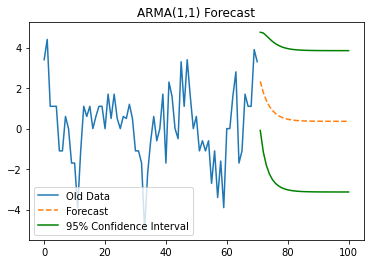

In [56]:
def arma_forecast(filename='weather.npy', phis=np.array([0]), thetas=np.array([0]), mu=0, std=0, n=30):
    """
    Forecast future observations of data.

    Parameters:
        file (str): data file
        phis (ndarray (p,)): coefficients of AR(p)
        thetas (ndarray (q,)): coefficients of MA(q)
        mu (float): mean of ARMA model
        std (float): standard deviation of ARMA model
        n (int): number of forecast observations
    """
    data = np.load(filename)
    Zt = np.diff(data)
    k = len(Zt)
    
    F,Q,H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)
    
    mus, covs = kalman(F,Q,H,Zt-np.ones(np.shape(Zt)[0])*mu)
    
    # Update
    y_tilda = Zt[-1]-H@mus[-1]
    S = H@covs[-1]@H.T
    K = covs[-1]@H.T@np.linalg.inv(S)
    X = mus[-1] + K@y_tilda
    Pkk = (np.eye(np.shape(K@H)[0]) - K@H)@covs[-1]
    
    new_mus = np.zeros(n+1)
    new_covs = np.zeros(n+1)
    
    # Convert back to Observation Space
    new_mus[0] = H@mus[-1] + mu
    new_covs[0] = H@covs[-1]@H.T
    
    # Iteratively Predict
    X,Pkk = [X],[Pkk]
    for t in range(n):
        # Predict
        X.append(F@X[t])
        Pkk.append(F@Pkk[t]@F.T + Q)
        # Convert back to Observation Space
        new_mus[t+1] = H@X[t+1] + mu
        new_covs[t+1] = H@Pkk[t+1]@H.T

        
    # Plot it
    plt.plot(np.diff(data), label="Old Data")
#     plt.plot([x for x in range(k, k+n)], [x[0] for x in X[1:]], alpha=.3, label="Forecast")
    plt.plot([x for x in range(k, k+n)], new_mus[1:], '--' , label="Forecast")
    plt.plot([x for x in range(k, k+n)], new_mus[1:] + new_covs[1:], c='g',label="95% Confidence Interval")
    plt.plot([x for x in range(k, k+n)], new_mus[1:] - new_covs[1:],c='g')
    plt.title("ARMA(1,1) Forecast")
    plt.legend()
    plt.show()
    
    
arma_forecast(phis=three[0], thetas=three[1], mu=three[2], std=three[3])

This does not look like problem 1, it is way more smooth

## Problem 5

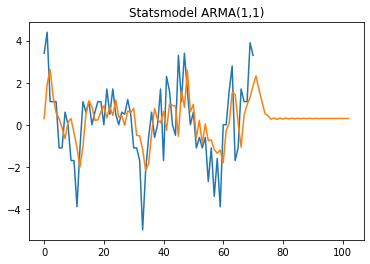

272.73413326171107

In [4]:
def sm_arma(filename='weather.npy', p_max=3, q_max=3, n=30):
    """
    Build an ARMA model with statsmodel and
    predict future n values.

    Parameters:
        filename (str): data filename
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model
        n (int): number of values to predict

    Return:
        aic (float): aic of optimal model
    """
    
    data = np.load(filename)
    z = np.diff(data)
    
    AIC = np.inf
    for p in range(1, p_max+1):
        for q in range(1, q_max+1):
            
            model = ARIMA(z, order=(p,0,q), trend='c').fit(method='innovations_mle')
            AIC_new = model.aic
            
            if AIC_new < AIC:
                p_best = p
                q_best = q
                AIC = AIC_new
                best_model = model
                
    # Plot it
    plt.plot(np.diff(data), label="Old Data")
    plt.plot(model.predict(start=0, end=len(data)+n), label="ARMA Model")
    plt.title("Statsmodel ARMA(1,1)")
    plt.show()
                
    return AIC
            
sm_arma()

This graph looks more similar to problem 4 than problem 1

## Problem 6

1959-03-31 00:00:00
2009-09-30 00:00:00


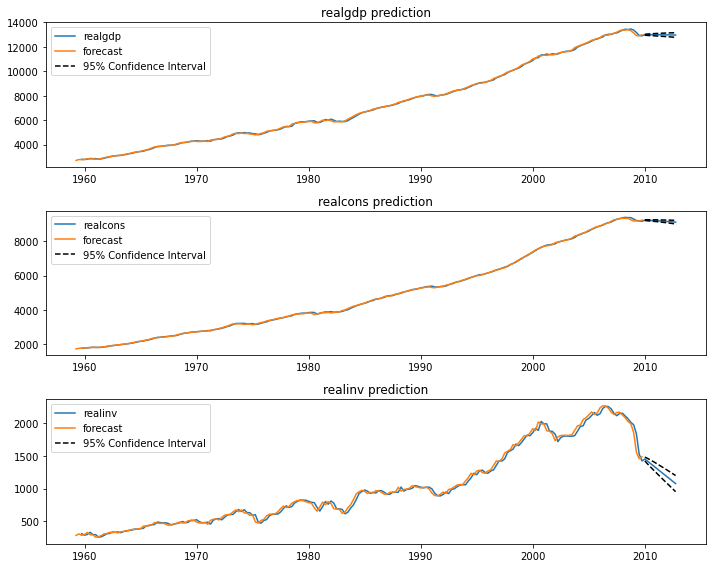

5972.5084688898005

In [58]:
def sm_varma(start='1959-09-30', end='2012-09-30'):
    """
    Build an VARMAX model with statsmodel and
    predict future n values.

    Parameters:
        start (str): the date at which to begin forecasting
        end (str): the date at which to stop forecasting

    Return:
        aic (float): aic of optimal model
    """
    
    df = sm.datasets.macrodata.load_pandas().data
    
    dates = df[['year', 'quarter']].astype(int).astype(str)
    dates = dates["year"] + "Q" + dates["quarter"]
    dates = dates_from_str(dates)
    print(dates[0])
    print(dates[-1])
    df.index = pd.DatetimeIndex(dates, freq="Q-DEC")
    
    cols = ['realgdp', 'realcons', 'realinv']
    df = df[['realgdp', 'realcons', 'realinv']]
    
    varmax = VARMAX(df)
    
    varmax = varmax.fit(maxiter=1000, disp=False, ic='aic')
    pred = varmax.predict(start, end)
    
    forecast_obj = varmax.get_forecast(end)
    all_CI = forecast_obj.conf_int(alpha=.5)

    
    plt.figure(figsize=(10,8))
    for i,col in enumerate(cols):
        plt.subplot(3,1,i+1)
        plt.plot(pred[col], label=col)
        plt.plot(df[col], label="forecast")
        plt.plot(all_CI[f"lower {col}"], '--', c='k', label="95% Confidence Interval")
        plt.plot(all_CI[f"upper {col}"], '--', c='k')
        plt.title(f"{col} prediction")
        plt.legend()
        
    plt.tight_layout()
    plt.show()
    
    return varmax.aic

sm_varma()